<a href="https://colab.research.google.com/github/a20121248/aprendizaje_automatico/blob/main/20121248_Modelos_de_Ensamble_Ejercicio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Métodos de ensamble

En este cuaderno de trabajo realizarás las siguientes actividades:
* Entrenarás tres modelos de clasificación y los combinarás utilizando ensamble por votación y ensamble por apilamiento
* Aplicarás búsqueda aleatoria y búsqueda en grilla para encontrar los mejores parámetros de un modelo de clasificación Random Forests
* Identificarás las características más importantes aprendidas en el entrenamiento de un modelo con Random Forests

# Ensamble por Bagging con Random Forests

En este ejercicio usaremos el conjunto de datos [Titanic: Machine Learning from Disaster](https://www.kaggle.com/c/titanic). A partir de un conjunto de características sobre cada pasajero se requiere predecir si sobrevivió o no a la tragedia. Ver la [descripción de los datos](https://www.kaggle.com/c/titanic/data)

En los siguientes pasos tenemos un ejemplo básico del proceso típico de aprendizaje de modelos predictivos.

## Obtención y carga de datos

In [2]:
import pandas as pd

titanic_train = pd.read_csv('https://raw.githubusercontent.com/RichieRk/Titanic_Dataset/main/train.csv')
titanic_test = pd.read_csv('https://raw.githubusercontent.com/RichieRk/Titanic_Dataset/main/test.csv')
titanic_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
titanic_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## Preparación de los datos

La columna `PassengerId` es un identificador único para cada pasajero, no nos sirve para encontrar patrones. Podríamos simplemente omitirla o quizás mejor marcarla como columna índice, que es lo que haremos a continuación.

In [4]:
titanic_train.set_index('PassengerId', inplace=True)
titanic_test.set_index('PassengerId', inplace=True)
titanic_train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Lidiando con los valores faltantes

Usando un simple conteo en el conjunto de entrenamiento, podemos verificar que falta algunos valores para `Embarked`, `Age` y sobre todo `Cabin`.

In [6]:
titanic_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


En el conjunto de prueba, vemos que falta también un dato en `Fare`:

In [7]:
titanic_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       332 non-null    float64
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      417 non-null    float64
 8   Cabin     91 non-null     object 
 9   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 35.9+ KB


Hay diversas maneras de lidiar con valores faltantes. En este ejercicio haremos las siguientes opciones:

* `Embarked`: Sólo falta dos valores en el conjunto de entrenamiento. Imputaremos la moda (valor más frecuente).

In [8]:
# Sólo hay dos valores faltantes NaN. La moda (valor más frecuente) es 'S'
titanic_train['Embarked'].value_counts(dropna=False)

Embarked
S      644
C      168
Q       77
NaN      2
Name: count, dtype: int64

In [9]:
# Registramos el índice (PassengerId) de los dos casos, y luego mostramos ambos registros
embarked_NaN = titanic_train[titanic_train['Embarked'].isnull()].index
print('Los PassengerId en los que falta Embarked son: ', embarked_NaN.values)
print(embarked_NaN)
titanic_train.loc[embarked_NaN]

Los PassengerId en los que falta Embarked son:  [ 62 830]
Index([62, 830], dtype='int64', name='PassengerId')


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [16]:
# Calculamos la moda
embarked_moda = titanic_train['Embarked'].mode()[0]
print("La moda (valor más frecuente) de Embarked en el conjunto de entrenamiento es: ", embarked_moda)

La moda (valor más frecuente) de Embarked en el conjunto de entrenamiento es:  S


In [17]:
# Imputamos la moda en los valores faltantes
titanic_train.loc[embarked_NaN,'Embarked'] = embarked_moda
titanic_train.loc[embarked_NaN]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,S
830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,S


`Age`: Incluiremos un campo booleano de `EdadDesconocida` y adicionalmente completaremos el valor con la mediana.

In [18]:
# Creamos una columna para caracterizar los casos con edad desconocida
titanic_train['EdadDesconocida'] = titanic_train['Age'].isnull()
titanic_test['EdadDesconocida'] = titanic_test['Age'].isnull()

# Calculamos la mediana de Age y la imputamos en los valores faltantes de ambos conjuntos
# Mostramos cómo hacerlo con DataFrame.fillna()
age_mediana = titanic_train['Age'].median()
print("La mediana del campo Age en el conjunto de entrenamiento es: ", age_mediana)

titanic_train['Age'].fillna(age_mediana, inplace=True)
titanic_test['Age'].fillna(age_mediana, inplace=True)

La mediana del campo Age en el conjunto de entrenamiento es:  28.0


* `Fare`: Un solo caso, en el conjunto de prueba. Imputaremos la mediana del conjunto de entrenamiento.

In [19]:
fare_mediana = titanic_train['Fare'].median()
print("La mediana del campo Fare en el conjunto de entrenamiento es: ", fare_mediana)

titanic_test['Fare'].fillna(fare_mediana, inplace=True)

La mediana del campo Fare en el conjunto de entrenamiento es:  14.4542


* `Cabin`: No usaremos la clase `Cabin`, en la cual faltan datos para el 77% de pasajeros.

In [22]:
titanic_train['Cabin'].isnull().sum() / len(titanic_train)

0.7710437710437711

In [23]:
titanic_train.drop(['Cabin'], axis=1, inplace=True)
titanic_test.drop(['Cabin'], axis=1, inplace=True)

### Selección e ingeniería de características

Ya hemos retirado la columna `Cabin`, severamente incompleta. Retiraremos también `Name` y `Ticket`, por ser campos irrelevantes para efectos de la predicción.

In [24]:
titanic_train.drop(['Name','Ticket'], axis=1, inplace=True)
titanic_test.drop(['Name','Ticket'], axis=1, inplace=True)

Podemos añadir otras meta-características. Por ejemplo, podríamos crear una columna `ViajaSolo` cuando no el pasajero no viajó  con ningún familiar: 0 `SibSp` (viaja con hermanos o cónyuge) y 0 `Parch` (viaja con padres o hijos).

In [25]:
titanic_train['ViajaSolo'] = ((titanic_train['SibSp'] + titanic_train['Parch']) == 0)
titanic_test['ViajaSolo'] = ((titanic_test['SibSp'] + titanic_test['Parch']) == 0)
titanic_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,EdadDesconocida,ViajaSolo
PassengerId,,,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S,False,False
2,1,1,female,38.0,1,0,71.2833,C,False,False
3,1,3,female,26.0,0,0,7.9250,S,False,True
4,1,1,female,35.0,1,0,53.1000,S,False,False
5,0,3,male,35.0,0,0,8.0500,S,False,True


In [26]:
titanic_test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,EdadDesconocida,ViajaSolo
PassengerId,,,,,,,,,
892,3,male,34.5,0,0,7.8292,Q,False,True
893,3,female,47.0,1,0,7.0000,S,False,False
894,2,male,62.0,0,0,9.6875,Q,False,True
895,3,male,27.0,0,0,8.6625,S,False,True
896,3,female,22.0,1,1,12.2875,S,False,False


Añadamos las columnas `MenorDeEdad` y `AdultoMayor`. Consideramos como menor de edad a todos aquellos menores de 18.0 años. Consideramos Adulto Mayor a los mayores de 55.0 años. Lo hacemos tanto en el conjunto de entrenamiento como en el de pruebas.

In [27]:
titanic_train['MenorDeEdad'] = (titanic_train['Age'] < 18)
titanic_test['MenorDeEdad'] = (titanic_test['Age'] < 18)

titanic_train['AdultoMayor'] = (titanic_train['Age'] > 55)
titanic_test['AdultoMayor'] = (titanic_test['Age'] > 55)



In [28]:
titanic_train['MenorDeEdad'].value_counts()

MenorDeEdad
False    778
True     113
Name: count, dtype: int64

**Pregunta:** ¿Cuántos menores de edad hay en el conjunto de entrenamiento?

**Respuesta:** Hay 113 menores de edad en el conjunto de entrenamiento.

In [29]:
titanic_test['AdultoMayor'].value_counts()

AdultoMayor
False    399
True      19
Name: count, dtype: int64

**Pregunta:** ¿Cuántos adultos mayores hay en el conjunto de pruebas?

**Respuesta:** Hay 19 adultos mayores en el conjunto de pruebas.

### Codificación de variables categóricas

Tenemos también tres variables categóricas (`Sex`, `Pclass` y `Embarked`). Las convertiremos en datos numéricos para que facilitar su entrenamiento por cualquier modelo.

* `Sex`: la podemos reemplazar por un valor binario `EsMujer` (0 = hombre; 1 = mujer).

In [30]:
titanic_train['EsMujer'] = (titanic_train['Sex'] == 'female')
titanic_test['EsMujer'] = (titanic_test['Sex'] == 'female')

titanic_train.drop(['Sex'], axis=1, inplace=True)
titanic_test.drop(['Sex'], axis=1, inplace=True)

* `Pclass` y `Embarked`: Usaremos *one-hot encoding* con la función `DataFrame.get_dummies` de `pandas`.

  `Pclass` es la clase en la que viajó el pasajero (1 = primera clase; 2 = segunda clase; 3 = tercera clase).

  `Embarked` es el puerto de embarque (C = Cherbourg; Q = Queenstown; S = Southampton).

  Observa que `Pclass` es categórica no obstante haya sido representada con una codificación numérica.

In [31]:
titanic_test.head()

,Pclass,Age,SibSp,Parch,Fare,Embarked,EdadDesconocida,ViajaSolo,MenorDeEdad,AdultoMayor,EsMujer
PassengerId,,,,,,,,,,,
892,3,34.5,0,0,7.8292,Q,False,True,False,False,False
893,3,47.0,1,0,7.0000,S,False,False,False,False,True
894,2,62.0,0,0,9.6875,Q,False,True,False,True,False
895,3,27.0,0,0,8.6625,S,False,True,False,False,False
896,3,22.0,1,1,12.2875,S,False,False,False,False,True


In [33]:
cols_categoricas = ['Pclass','Embarked']

titanic_train = pd.get_dummies(titanic_train, columns=cols_categoricas)
titanic_test = pd.get_dummies(titanic_test, columns=cols_categoricas)

titanic_train.head()

,Survived,Age,SibSp,Parch,Fare,EdadDesconocida,ViajaSolo,MenorDeEdad,AdultoMayor,EsMujer,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,,,,,,,
1,0,22.0,1,0,7.2500,False,False,False,False,False,False,False,True,False,False,True
2,1,38.0,1,0,71.2833,False,False,False,False,True,True,False,False,True,False,False
3,1,26.0,0,0,7.9250,False,True,False,False,True,False,False,True,False,False,True
4,1,35.0,1,0,53.1000,False,False,False,False,True,True,False,False,False,False,True
5,0,35.0,0,0,8.0500,False,True,False,False,False,False,False,True,False,False,True


In [34]:
titanic_test.head()

,Age,SibSp,Parch,Fare,EdadDesconocida,ViajaSolo,MenorDeEdad,AdultoMayor,EsMujer,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,,,,,,
892,34.5,0,0,7.8292,False,True,False,False,False,False,False,True,False,True,False
893,47.0,1,0,7.0000,False,False,False,False,True,False,False,True,False,False,True
894,62.0,0,0,9.6875,False,True,False,True,False,False,True,False,False,True,False
895,27.0,0,0,8.6625,False,True,False,False,False,False,False,True,False,False,True
896,22.0,1,1,12.2875,False,False,False,False,True,False,False,True,False,False,True


## Separación de conjunto para validación

In [37]:
from sklearn.model_selection import train_test_split

X_train_val = titanic_train.drop('Survived', axis=1)
y_train_val = titanic_train['Survived']

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=0)

# Ensamble por votación manual

Combinemos en un modelo de ensamble por votación las probabilidades de clase asignadas por tres clasificadores de base: un árbol de decisión (`DecisionTreeClassifier`), un modelo k-NN (`KNeighborsClassifier`), y una máquina de soporte vectorial con kernel gaussiano (`SVC`).

Asignemos manualmente a los modelos los pesos `[2, 1, 2]`, lo que significa que, al promediar las probabilidades obtenidas de los modelos, las probabilidades del árbol de decisión y de la máquina de soporte vectorial cuentan el doble que las del modelo k-NN.

In [38]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

estimators = [
     ('árbol de decisión', DecisionTreeClassifier(max_depth=4)),
     ('k-NN', make_pipeline(StandardScaler(),
                            KNeighborsClassifier(n_neighbors=7) )),
     ('SVM de kernel gaussiano', make_pipeline(StandardScaler(),
                                               SVC(kernel='rbf', probability=True) ))
]

ensamble = VotingClassifier(estimators=estimators,
                        voting='soft', weights=[2, 1, 2])
ensamble.fit(X_train, y_train)

for (name, estimator) in ensamble.named_estimators_.items():
  print(f'Exactitud de {name: <25}: Entrenamiento {estimator.score(X_train, y_train):.03f} || Validación {estimator.score(X_val, y_val):.03f}',  )

print(f'Exactitud de {"ensamble": <25}: Entrenamiento {ensamble.score(X_train, y_train):.03f} || Validación {ensamble.score(X_val, y_val):.03f}' )

Exactitud de árbol de decisión        : Entrenamiento 0.844 || Validación 0.816
Exactitud de k-NN                     : Entrenamiento 0.834 || Validación 0.832
Exactitud de SVM de kernel gaussiano  : Entrenamiento 0.848 || Validación 0.810
Exactitud de ensamble                 : Entrenamiento 0.854 || Validación 0.832


Observemos la exactitud *(accuracy)* de cada uno los modelos:

## Ensamble por Apilamiento *(Stacking)* con Regresión logística

En el ejemplo anterior, se asignó manualmente los pesos a los modelos de base. Tratemos ahora de emplear las predicciones probabilísticas de los modelos de base para entrenar nuestro modelo de ensamble. Como algoritmo de aprendizaje usaremos la regresión logística.

In [40]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

ensamble = StackingClassifier(estimators=estimators,
                              final_estimator=LogisticRegression(penalty='l2') )
ensamble.fit(X_train, y_train)

StackingClassifier(estimators=[('árbol de decisión',
                                DecisionTreeClassifier(max_depth=4)),
                               ('k-NN',
                                Pipeline(steps=[('standardscaler',
                                                 StandardScaler()),
                                                ('kneighborsclassifier',
                                                 KNeighborsClassifier(n_neighbors=7))])),
                               ('SVM de kernel gaussiano',
                                Pipeline(steps=[('standardscaler',
                                                 StandardScaler()),
                                                ('svc',
                                                 SVC(probability=True))]))],
                   final_estimator=LogisticRegression())

In [41]:
for (name, estimator) in ensamble.named_estimators_.items():
  print(f'Exactitud de {name: <25}: Entrenamiento {estimator.score(X_train, y_train):.03f} || Validación {estimator.score(X_val, y_val):.03f}',  )

print(f'Exactitud de {"ensamble": <25}: Entrenamiento {ensamble.score(X_train, y_train):.03f} || Validación {ensamble.score(X_val, y_val):.03f}' )

Exactitud de árbol de decisión        : Entrenamiento 0.844 || Validación 0.816
Exactitud de k-NN                     : Entrenamiento 0.834 || Validación 0.832
Exactitud de SVM de kernel gaussiano  : Entrenamiento 0.848 || Validación 0.810
Exactitud de ensamble                 : Entrenamiento 0.858 || Validación 0.832


## Ensamble por Bagging con Random Forests

Antes de realizar una búsqueda de los mejores parámetros de entrenamiento, ajustemos primero un modelo Random Forest con los parámetros que trae por defecto.

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf = RandomForestClassifier(oob_score = True)
rf.fit(X_train, y_train)

print('Exactitud del modelo inicial en entrenamiento:', rf.score(X_train, y_train))
print('Exactitud del modelo inicial en entrenamiento (Out of Bag):', rf.oob_score_)
print('Exactitud del modelo inicial en validación:', rf.score(X_val, y_val))

Exactitud del modelo inicial en entrenamiento: 0.9817415730337079
Exactitud del modelo inicial en entrenamiento (Out of Bag): 0.8061797752808989
Exactitud del modelo inicial en validación: 0.8212290502793296


### Búsqueda aleatoria de hiperparámetros

El clasificador de Random Forest tiene diversos parámetros que pueden ser optimizados. Se puede ver la documentación de [sklearn.ensemble.RandomForestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

Los principales hiperparámetros de Random Forest son:
- `n_estimators` -- el número de modelos base (árboles) a entrenar
- `max_features` -- el número de características a considerar en cada partición de los árboles
- `max_depth` -- la profundidad máxima de los árboles
- `min_samples_leaf` -- el numero mínimo de muestras que deben quedar en cada hoja del árbol

Para identificar los mejores valores de los hiperparámetros usaremos primero búsqueda aleatoria y luego búsqueda en grilla.

In [47]:
from pprint import pprint
import numpy as np

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 8, 10, 12, None]  # 'auto' equivale a 'sqrt'; None equivale a todas las 15
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)] + [None]
min_samples_leaf = [1, 2, 4]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_leaf': min_samples_leaf}

print('Los valores a probar en la búsqueda aleatoria son:')
pprint(random_grid)

print()
print('El número total de combinaciones de parámetros de entrenamiento es',
      len(random_grid['n_estimators']) *
      len(random_grid['max_features']) *
      len(random_grid['max_depth']) *
      len(random_grid['min_samples_leaf'])
      )

Los valores a probar en la búsqueda aleatoria son:
{'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 8, 10, 12, None],
 'min_samples_leaf': [1, 2, 4],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

El número total de combinaciones de parámetros de entrenamiento es 1800


Probaremos entrenando sólo un 1% de las combinaciones posibles, es decir, 18. (Se recomienda probar al menos un 10%)

In [48]:
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestClassifier(oob_score=True)
rf_random = RandomizedSearchCV(estimator = rf,
                               param_distributions = random_grid,
                               n_iter = 18,
                               cv = 3,          # Validación cruzada 3-fold
                               verbose=2,
                               random_state=0,
                               n_jobs = -1      # Paralelizar en todos los cores disponibles
                               )
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(oob_score=True),
                   n_iter=18, n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 8, 10, 12,
                                                         None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=0, verbose=2)

In [49]:
rf_random_best = rf_random.best_estimator_

print('Los hiperparámetros del mejor modelo son:')
pprint(rf_random.best_params_)
print()

print('Exactitud luego de búsqueda aleatoria en entrenamiento:', rf_random_best.score(X_train, y_train))
print('Exactitud luego de búsqueda aleatoria en entrenamiento (Out of Bag):', rf_random_best.oob_score_)
print('Exactitud luego de búsqueda aleatoria en validación:', rf_random_best.score(X_val, y_val))

Los hiperparámetros del mejor modelo son:
{'max_depth': None,
 'max_features': 10,
 'min_samples_leaf': 4,
 'n_estimators': 400}

Exactitud luego de búsqueda aleatoria en entrenamiento: 0.8890449438202247
Exactitud luego de búsqueda aleatoria en entrenamiento (Out of Bag): 0.824438202247191
Exactitud luego de búsqueda aleatoria en validación: 0.8435754189944135


In [50]:
max_features = [9, 10, 11]
max_depth = [47, 50, 53]
min_samples_leaf = [4]
n_estimators = [1000]

segundo_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_leaf': min_samples_leaf}

print('Los valores a probar en la búsqueda por grilla son:')
pprint(segundo_grid)

Los valores a probar en la búsqueda por grilla son:
{'max_depth': [47, 50, 53],
 'max_features': [9, 10, 11],
 'min_samples_leaf': [4],
 'n_estimators': [1000]}


In [51]:
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(oob_score = True)
rf_grid = GridSearchCV(estimator = rf,
                        param_grid = segundo_grid,
                        cv = 3,          # Validación cruzada 3-fold
                        verbose=2,
                        n_jobs = -1      # Paralelizar en todos los cores disponibles
                        )
rf_grid.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(oob_score=True), n_jobs=-1,
             param_grid={'max_depth': [47, 50, 53], 'max_features': [9, 10, 11],
                         'min_samples_leaf': [4], 'n_estimators': [1000]},
             verbose=2)

In [52]:
rf_grid_best = rf_grid.best_estimator_

print('Los hiperparámetros del mejor modelo son:')
pprint(rf_grid.best_params_)
print()

print('Exactitud luego de búsqueda en grilla en entrenamiento:', rf_grid_best.score(X_train, y_train))
print('Exactitud luego de búsqueda en grilla en entrenamiento (Out of Bag):', rf_grid_best.oob_score_)
print('Exactitud luego de búsqueda en grilla en validación:', rf_grid_best.score(X_val, y_val))

Los hiperparámetros del mejor modelo son:
{'max_depth': 47,
 'max_features': 9,
 'min_samples_leaf': 4,
 'n_estimators': 1000}

Exactitud luego de búsqueda en grilla en entrenamiento: 0.8918539325842697
Exactitud luego de búsqueda en grilla en entrenamiento (Out of Bag): 0.8230337078651685
Exactitud luego de búsqueda en grilla en validación: 0.8435754189944135


### Curva ROC

AUC = 0.8980237154150197


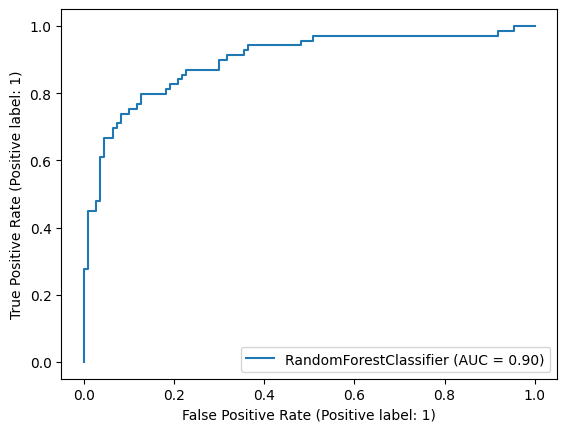

In [56]:
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

y_pred_val = rf_grid_best.predict_proba(X_val)[:,1]
auc_roc = metrics.roc_auc_score(y_val, y_pred_val)
print('AUC =', auc_roc)

metrics.RocCurveDisplay.from_estimator(rf_grid_best, X_val, y_val)

## Visualización de las características más importantes



<ipython-input-57-5fc7b102223b>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(feature_names[sorted_idx])


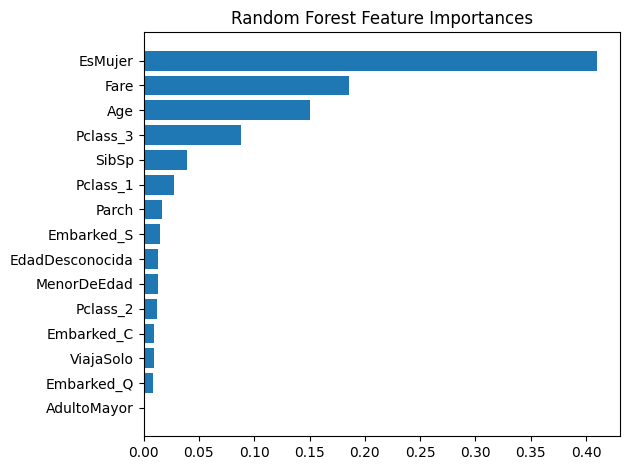

In [57]:
feature_names = X_train.columns.values
tree_feature_importances = rf_grid_best.feature_importances_
sorted_idx = tree_feature_importances.argsort()

y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots()
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances")
fig.tight_layout()
plt.show()

# Otros modelos de ensamble

Prueba a entrenar ensambles con por lo menos otras dos [estrategias](https://scikit-learn.org/stable/modules/ensemble.html#). Puedes intentar, por ejemplo, con [AdaBoost](https://scikit-learn.org/stable/modules/ensemble.html#adaboost), [Gradient Boosting](https://scikit-learn.org/stable/modules/ensemble.html#gradient-tree-boosting) o [XGBoost](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn) ([ejemplos](https://github.com/dmlc/xgboost/blob/master/demo/guide-python/sklearn_examples.py)\)

### AdaBoost

In [76]:
from sklearn.ensemble import AdaBoostClassifier

params = {
    'n_estimators': 50,
    'learning_rate': 0.1
}

adb = AdaBoostClassifier(**params)
adb.fit(X_train, y_train)

print('Exactitud luego de búsqueda aleatoria en entrenamiento:', adb.score(X_train, y_train))
print('Exactitud luego de búsqueda aleatoria en validación:', adb.score(X_val, y_val))

Exactitud luego de búsqueda aleatoria en entrenamiento: 0.8075842696629213
Exactitud luego de búsqueda aleatoria en validación: 0.7932960893854749


### Gradient Boosting

In [78]:
from sklearn.ensemble import GradientBoostingClassifier

params = {
    'subsample': 0.6,
    'n_estimators': 200,
    'min_samples_split': 5,
    'min_samples_leaf': 2,
    'max_features': 'log2',
    'max_depth': 4,
    'learning_rate': 0.01
}

gbo = GradientBoostingClassifier(**params)
gbo.fit(X_train, y_train)

print('Exactitud luego de búsqueda aleatoria en entrenamiento:', gbo.score(X_train, y_train))
print('Exactitud luego de búsqueda aleatoria en validación:', gbo.score(X_val, y_val))

Exactitud luego de búsqueda aleatoria en entrenamiento: 0.851123595505618
Exactitud luego de búsqueda aleatoria en validación: 0.8324022346368715


### XGBoost

In [81]:
from xgboost import XGBClassifier

params = {
    'subsample': 0.6,
    'n_estimators': 150,
    'min_child_weight': 1,
    'max_depth': 6,
    'learning_rate': 0.01,
    'gamma': 0.2,
    'colsample_bytree': 1.0
}

xgb = XGBClassifier(**params)
xgb.fit(X_train, y_train)

print('Exactitud luego de búsqueda aleatoria en entrenamiento:', xgb.score(X_train, y_train))
print('Exactitud luego de búsqueda aleatoria en validación:', xgb.score(X_val, y_val))

Exactitud luego de búsqueda aleatoria en entrenamiento: 0.8707865168539326
Exactitud luego de búsqueda aleatoria en validación: 0.8379888268156425


### BaggingClassifier
#### Usamos el modelo XGBoost

In [84]:
from sklearn.ensemble import BaggingClassifier
from xgboost import XGBClassifier

xgb_params = {
    'subsample': 0.6,
    'n_estimators': 150,
    'min_child_weight': 1,
    'max_depth': 6,
    'learning_rate': 0.01,
    'gamma': 0.2,
    'colsample_bytree': 1.0
}

bagging_xgb = BaggingClassifier(base_estimator=XGBClassifier(**xgb_params), n_estimators=10, random_state=42)
bagging_xgb.fit(X_train, y_train)

print('Exactitud Bagging XGBoost en entrenamiento:', bagging_xgb.score(X_train, y_train))
print('Exactitud Bagging XGBoost en validación:', bagging_xgb.score(X_val, y_val))

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Exactitud Bagging XGBoost en entrenamiento: 0.8595505617977528
Exactitud Bagging XGBoost en validación: 0.8268156424581006
